# MIA vs Overfitting

In this notebook we will study the effect of overfitting in MIA's performance, given a CNN model, CIFAR-10 dataset and a MIA framework that will perfrom the attacks for us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
!cp ../input/mia-v2 ./mia_v2 -r
from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm.notebook import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2022-03-14 22:46:20.084905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:46:20.200722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:46:20.201498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-4, patience=20)

In [3]:
def f_target(X_train, y_train, X_test, y_test, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_data=(X_test, y_test),
                      callbacks=[es]
                      )
  return model, history

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
print(f"We have {len(train_images)} train instances and {len(test_images)} test instances.")

We have 50000 train instances and 10000 test instances.


Let us give the attacker 10000 data points and let the rest of them be training-evaluation-testing datapoints for the target model.

In [6]:
attacker_images, attacker_labels = (test_images, test_labels)
N_SHADOWS = 5
D_SHADOW= 5000

In [7]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-7)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [8]:
attack = ConfidenceVectorAttack(None, (train_images, train_labels), 
                                  (attacker_images, attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW, verbose=True)
attack.perform_attack(shadow={'epochs':100, 'batch_size':64, 'callbacks':[es]})

2022-03-14 22:46:26.652434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 22:46:26.653791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:46:26.654610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:46:26.655265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/100


2022-03-14 22:46:30.514014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


53/53 [==============================] - 8s 10ms/step - loss: 6.0330 - accuracy: 0.1469 - val_loss: 2.2055 - val_accuracy: 0.1673
Epoch 2/100
53/53 [==============================] - 0s 8ms/step - loss: 2.1489 - accuracy: 0.2006 - val_loss: 2.1480 - val_accuracy: 0.1782
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 2.0638 - accuracy: 0.2334 - val_loss: 2.0609 - val_accuracy: 0.2194
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 1.9813 - accuracy: 0.2767 - val_loss: 1.9999 - val_accuracy: 0.2509
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 1.9166 - accuracy: 0.3057 - val_loss: 1.9636 - val_accuracy: 0.2697
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 1.8298 - accuracy: 0.3361 - val_loss: 1.9412 - val_accuracy: 0.2764
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 1.8082 - accuracy: 0.3531 - val_loss: 1.9847 - val_accuracy: 0.2861
Epoch 8/100
53/53 [=====

Epoch 1/100
63/63 [==============================] - 3s 49ms/step - loss: 2.1198 - accuracy: 0.2745 - val_loss: 1.8981 - val_accuracy: 0.3227
Epoch 2/100
63/63 [==============================] - 3s 44ms/step - loss: 1.6848 - accuracy: 0.4000 - val_loss: 1.8040 - val_accuracy: 0.3351
Epoch 3/100
63/63 [==============================] - 2s 39ms/step - loss: 1.5102 - accuracy: 0.4610 - val_loss: 1.7157 - val_accuracy: 0.3985
Epoch 4/100
63/63 [==============================] - 2s 35ms/step - loss: 1.3994 - accuracy: 0.5020 - val_loss: 1.6859 - val_accuracy: 0.4114
Epoch 5/100
63/63 [==============================] - 3s 44ms/step - loss: 1.1825 - accuracy: 0.5865 - val_loss: 1.7265 - val_accuracy: 0.4029
Epoch 6/100
63/63 [==============================] - 3s 44ms/step - loss: 1.0082 - accuracy: 0.6475 - val_loss: 1.6537 - val_accuracy: 0.4339
Epoch 7/100
63/63 [==============================] - 3s 44ms/step - loss: 0.8252 - accuracy: 0.7325 - val_loss: 1.6590 - val_accuracy: 0.4360
Epoch 

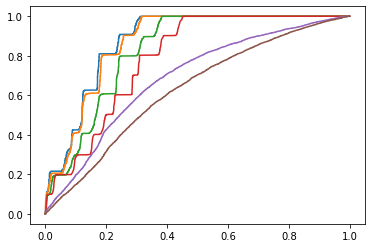

In [9]:
scores = []
history = []

for dataset_size in [2000, 2500, 5000, 7500, 10000, 20000]:
  X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, train_size=dataset_size)
  target_model, h = f_target(X_train, y_train, X_test, y_test, epochs=100)
  history.append(h)

  attack.target_model = target_model
  attack.target_dataset = X_train, y_train
  _score = attack.evaluate_attack()
  scores.append(_score)



In [10]:
epochs = [2000, 2500, 5000, 7500, 10000, 20000]

Text(0, 0.5, 'AUC Score')

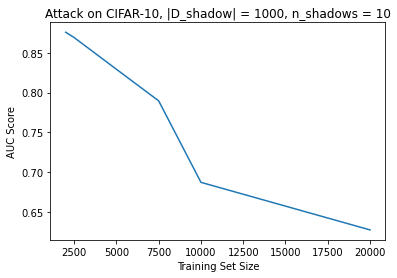

In [11]:
auc_scores = [items[1] for items in scores]

plt.plot(epochs, auc_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')

Text(0, 0.5, 'Recall Score')

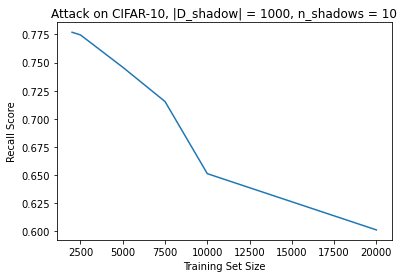

In [12]:
recall_scores = [items[0]['macro avg']['recall'] for items in scores]

plt.plot(epochs, recall_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')

Text(0, 0.5, 'Precision Score')

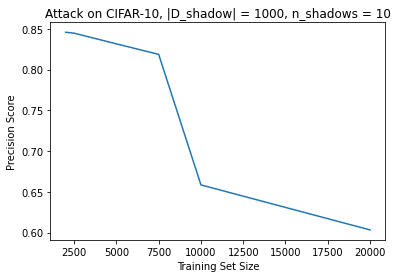

In [13]:
precision_scores = [items[0]['macro avg']['precision'] for items in scores]

plt.plot(epochs, precision_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

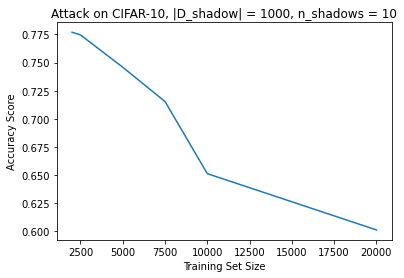

In [14]:
accuracy_scores = [items[0]['accuracy'] for items in scores]

plt.plot(epochs, accuracy_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')